In [17]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.metrics import mean_squared_error
import torch
import numpy as np
from scipy.stats import pearsonr
from transformers import BertForSequenceClassification, AdamW
from tqdm import tqdm

train_df = pd.read_csv('train.csv', sep='\t')
dev_df = pd.read_csv('dev.csv', sep='\t')

class TextSimilarityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence1 = str(self.data.iloc[idx]['sentence1'])
        sentence2 = str(self.data.iloc[idx]['sentence2'])
        label = float(self.data.iloc[idx]['score']) / 5.0

        encoding = self.tokenizer(sentence1, sentence2, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.float)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TextSimilarityDataset(train_df, tokenizer)
dev_dataset = TextSimilarityDataset(dev_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

import matplotlib.pyplot as plt

train_losses = []
valid_losses = []


epochs = 3
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].unsqueeze(1).to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()


    avg_train_loss = total_loss / len(train_loader)
    print(f'Average Training Loss: {avg_train_loss:.4f}')



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\varma\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


Training: 100%|██████████| 357/357 [31:25<00:00,  5.28s/it]


Average Training Loss: 0.0564
Epoch 2/3


Training: 100%|██████████| 357/357 [30:14<00:00,  5.08s/it]


Average Training Loss: 0.0256
Epoch 3/3


Training: 100%|██████████| 357/357 [32:44<00:00,  5.50s/it]

Average Training Loss: 0.0183


In [18]:
model.eval()
predictions = []
true_labels = []
total_valid_loss = 0

for batch in tqdm(dev_loader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].unsqueeze(1).to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_valid_loss += loss.item()
            valid_losses.append(loss.item())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

pearson_corr, _ = pearsonr(predictions, true_labels)
print(f'Pearson Correlation: {pearson_corr:.4f}')


Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:  72%|███████▏  | 66/92 [04:13<01:42,  3.93s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating: 100%|██████████| 92/92 [05:54<00:00,  3.85s/it]

Pearson Correlation: 0.8645


In [19]:

model.save_pretrained('./model1A/')

tokenizer.save_pretrained('./model1A/')


('./model1A/tokenizer_config.json',
 './model1A/special_tokens_map.json',
 './model1A/vocab.txt',
 './model1A/added_tokens.json')

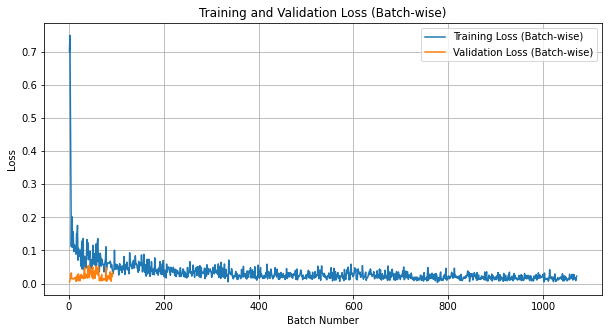

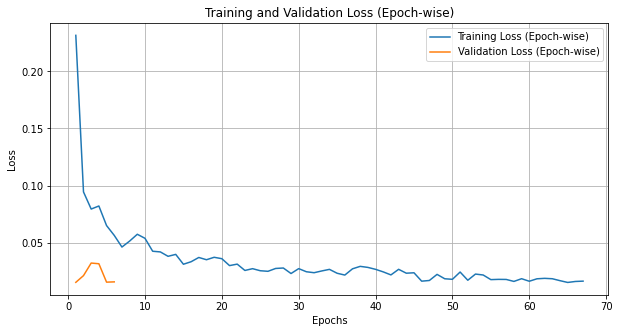

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss (Batch-wise)')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss (Batch-wise)')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Batch-wise)')
plt.legend()
plt.grid(True)
plt.show()

def aggregate_losses(batch_losses, batch_size):
    epoch_losses = []
    for i in range(0, len(batch_losses), batch_size):
        epoch_loss = sum(batch_losses[i:i + batch_size]) / batch_size
        epoch_losses.append(epoch_loss)
    return epoch_losses

batch_size = 16

train_losses_epoch = aggregate_losses(train_losses, batch_size)
valid_losses_epoch = aggregate_losses(valid_losses, batch_size)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses_epoch) + 1), train_losses_epoch, label='Training Loss (Epoch-wise)')
plt.plot(range(1, len(valid_losses_epoch) + 1), valid_losses_epoch, label='Validation Loss (Epoch-wise)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Epoch-wise)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
avg_valid_loss = total_valid_loss / len(dev_loader)
print(f'Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_valid_loss:.4f}')
print(f'Pearson Correlation: {pearson_corr:.4f}')

Average Training Loss: 0.0183, Average Validation Loss: 0.0228
Pearson Correlation: 0.8645
